# Prepare MLH Data

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import pdb
import pandas as pd
import numpy as np
import pickle
np.set_printoptions(precision=4)

from tqdm import tqdm_notebook as tqdm
from ast import literal_eval
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
path = Path('data')
workdir = path/'workdir'
figdir = workdir/'figures'

## Functions

In [4]:
def note_interval(x):
  if pd.isnull(x):
    return -1
  
  if 0 < x <= 1:
    return 0
  elif 1 < x <= 2:
    return 1
  elif 2 < x <= 3:
    return 2
  elif 3 < x <= 4:
    return 3
  elif 4 < x <= 5:
    return 4
  elif 5 < x <= 6:
    return 5
  elif 6 < x <= 7:
    return 6
  elif 7 < x <= 8:
    return 7
  elif 8 < x <= 9:
    return 8
  elif 9 < x <= 10:
    return 9
  elif 10 < x <= 11:
    return 10
  elif 11 < x <= 12:
    return 11
  elif 12 < x <= 13:
    return 12
  elif 13 < x <= 14:
    return 13
  elif 14 < x <= 15:
    return 14
  else:
    return 15

def icu_adm_label(x):
  if 0 <= x <= 1:
    return -1 # unused notes due to data leakage
  elif 1 < x <= 3:
    return 1 # imminent ICU admission
  elif 3 < x <= 5:
    return -1 # unused notes due to data leakage
  else:
    return 0 # delayed ICU admission

## Preprocessing

In [3]:
notes_df = pd.read_csv(path/'unstructured_raw.csv', parse_dates=['intime', 'admittime', 'ne_charttime', 'patient_dob', 'discttime', 'outtime'])
print(notes_df.shape)
notes_df.columns

(479536, 11)


Index(['hadm_id', 'subject_id', 'admittime', 'discttime', 'patient_gender',
       'patient_dob', 'patient_race', 'ne_charttime', 'note', 'intime',
       'outtime'],
      dtype='object')

In [5]:
notes_df.drop_duplicates(inplace=True)
notes_df.shape

(473420, 11)

In [6]:
notes_df['admission_age'] = ((notes_df['admittime'] - notes_df['patient_dob'])/np.timedelta64(1, 'Y')).astype(np.int64)

notes_df['los'] = (notes_df['outtime'] - notes_df['intime'])/np.timedelta64(1, 'D')
notes_df['admit_to_icu'] = (notes_df['intime'] - notes_df['admittime'])/np.timedelta64(1, 'D')

notes_df['note_to_icu'] = (notes_df['intime'] - notes_df['ne_charttime'])/np.timedelta64(1, 'D')
notes_df['note_len'] = notes_df['note'].apply(len)

Drop rows corresponding to patients of age at admission less than 15 years

In [7]:
notes_df = notes_df.loc[(notes_df['admission_age'] >= 15)].reset_index(drop=True)
notes_df.shape

(359149, 16)

Only include those rows:
1. where the notes of those rows were recorded between ICU start time if that patient got admitted to the ICU
2. where the patient did not go to the ICU at all (i.e., ICU start time is null)

In [8]:
notes_df = notes_df.loc[((notes_df['ne_charttime'] >= notes_df['admittime']) & (notes_df['ne_charttime'] < notes_df['intime'])) | (notes_df['intime'].isna())].reset_index(drop=True)
notes_df.shape

(133330, 16)

In [9]:
notes_df['interval'] = notes_df['note_to_icu'].apply(note_interval)
notes_df['imi_adm_label'] = notes_df['interval'].apply(icu_adm_label)

In [10]:
g = notes_df.loc[notes_df['imi_adm_label'] != -1].groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class across ALL notes:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class across ALL notes:3.4%


In [11]:
notes_df.to_csv(path/'unstructured_proc.csv', index=False)

## Explore

In [12]:
notes_df = pd.read_csv(path/'unstructured_proc.csv', parse_dates=['admittime', 'discttime', 'patient_dob', 'ne_charttime', 'intime', 'outtime'])
model_df = notes_df[notes_df['imi_adm_label'] != -1].reset_index(drop=True)
print(model_df.shape, notes_df.shape)

(116400, 18) (133330, 18)


In [13]:
notes_df['hadm_id'].nunique()

3842

In [14]:
print(f"Number of patients in notes cohort: {model_df['subject_id'].nunique()}")

Number of patients in notes cohort: 2508


In [15]:
g = model_df.groupby('imi_adm_label').size().to_numpy()
print(f"Prelavence: {g[1]} ({(g[1]/g.sum())*100:0.1f}%)")

Prelavence: 3919 (3.4%)


In [16]:
g = model_df.groupby('patient_gender')['subject_id'].nunique().to_numpy()
print(f"Males in notes cohort: {g[1]} ({(g[1]/g.sum())*100:0.1f}%)")

print(f"Mean:{model_df.groupby('subject_id')['admission_age'].first().mean():0.1f}")
print(f"STD:{model_df.groupby('subject_id')['admission_age'].first().std():0.1f}")
print(f"25th percentile:{model_df.groupby('subject_id')['admission_age'].first().quantile(0.25):0.1f}")
print(f"75th percentile:{model_df.groupby('subject_id')['admission_age'].first().quantile(0.75):0.1f}")

Males in notes cohort: 1276 (50.9%)
Mean:61.8
STD:17.5
25th percentile:54.0
75th percentile:74.0


In [17]:
g = model_df.groupby('patient_gender')['subject_id'].nunique().to_numpy()
print(f"Males in notes cohort: {g[1]} ({(g[1]/g.sum())*100:0.1f}%)")

Males in notes cohort: 1276 (50.9%)


In [18]:
print(f"Mean:{model_df.groupby('subject_id')['admission_age'].first().mean():0.1f}")
print(f"STD:{model_df.groupby('subject_id')['admission_age'].first().std():0.1f}")
print(f"25th percentile:{model_df.groupby('subject_id')['admission_age'].first().quantile(0.25):0.1f}")
print(f"75th percentile:{model_df.groupby('subject_id')['admission_age'].first().quantile(0.75):0.1f}")

Mean:61.8
STD:17.5
25th percentile:54.0
75th percentile:74.0


In [19]:
g = pd.DataFrame(model_df.groupby('patient_race')['subject_id'].nunique()).reset_index()
g.columns = ['patient_race', 'count']
g['pct'] = np.round((g['count']/g['count'].sum() * 100), 1)
print(g)

                 patient_race  count   pct
0  Amer. Indian/Alaska Native      4   0.2
1                       Asian     12   0.5
2   Black or African American   1396  55.7
3                    Declined      1   0.0
4               Other/Unknown     67   2.7
5                 Unavailable      5   0.2
6                       White   1023  40.8


In [20]:
print("Encounter time to ICU Admission for model cohort:")
print(f"Mean:{model_df['admit_to_icu'].mean():0.1f}")
print(f"STD:{model_df['admit_to_icu'].std():0.1f}")
print(f"25th percentile:{model_df['admit_to_icu'].quantile(0.25):0.1f}")
print(f"75th percentile:{model_df['admit_to_icu'].quantile(0.75):0.1f}")

Encounter time to ICU Admission for model cohort:
Mean:17.6
STD:20.0
25th percentile:7.4
75th percentile:19.2


In [21]:
print(f"Average Number of clinical notes per encounter for model cohort: {(len(model_df)/model_df['hadm_id'].nunique()):0.1f}")

Average Number of clinical notes per encounter for model cohort: 43.0


In [22]:
print("Clinical Note Length for model cohort:")
print(f"Mean:{model_df['note_len'].mean():0.1f}")
print(f"STD:{model_df['note_len'].std():0.1f}")
print(f"25th percentile:{model_df['note_len'].quantile(0.25):0.1f}")
print(f"75th percentile:{model_df['note_len'].quantile(0.75):0.1f}")

Clinical Note Length for model cohort:
Mean:4333.4
STD:6818.0
25th percentile:667.0
75th percentile:6094.0


Text(0, 0.5, '# notes')

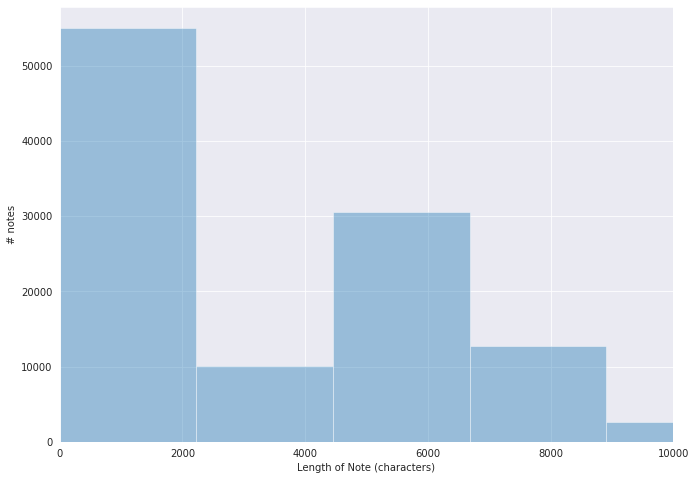

In [24]:
# Note length distribution
fig, ax = plt.subplots(figsize=(11, 8))
sns.distplot(model_df['note_len'], kde=False, ax=ax, bins=100)
ax.set_xlim(0, 10000)
ax.set_xlabel('Length of Note (characters)')
ax.set_ylabel('# notes')

# fig.savefig(figdir/'note_len_dist.pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0)

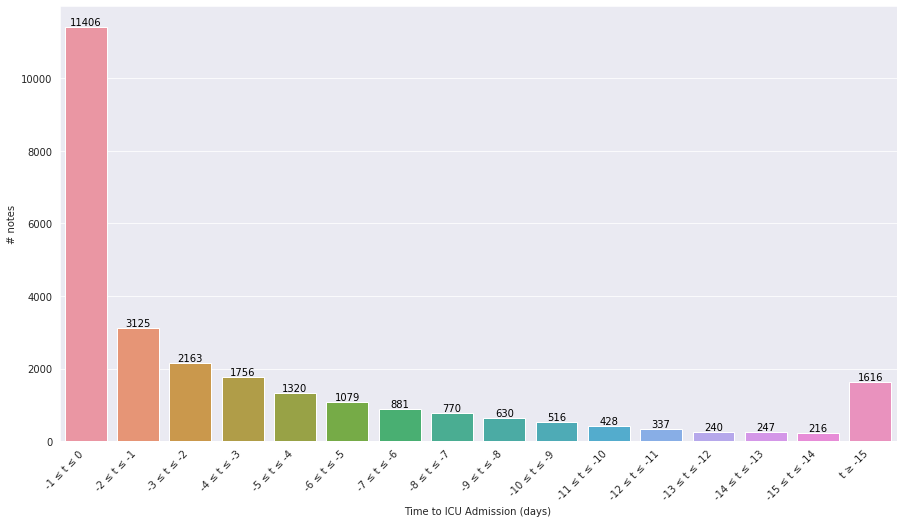

In [25]:
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≥ -15')

plot_df = pd.DataFrame(notes_df.loc[notes_df['interval'] != -1].groupby('interval').size(), columns=['n_notes']).reset_index(drop=True)
plot_df['days'] = intervals

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='days', y='n_notes', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel('Time to ICU Admission (days)')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
    ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')
    
# fig.savefig(figdir/f'admit_to_icu_binned_dist.pdf', dpi=300)        

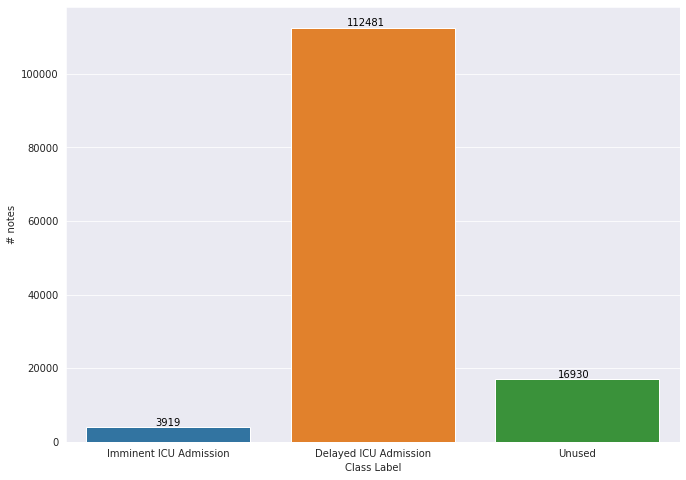

In [26]:
desc = ['Unused', 'Delayed ICU Admission', 'Imminent ICU Admission']

p = pd.DataFrame(notes_df.groupby(['imi_adm_label']).size(), columns=['n_notes']).reset_index()
# p1 = pd.DataFrame(notes_df.groupby(['imi_adm_label']).size(), columns=['n_notes']).reset_index()
# p2 = notes_df.groupby(['imi_adm_label'])['hadm_id'].nunique().reset_index()

# p = p1.merge(p2, on=['imi_adm_label'])
p['imi_adm_label'] = desc
p = p.reindex([2, 1, 0])
# p.reset_index(inplace=True, drop=True)

plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Encounters', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='imi_adm_label', var_name='Legend', value_name='counts')

plot_df

fig, ax = plt.subplots(figsize=(11, 8))
sns.barplot(x='imi_adm_label', y='counts', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='center')
ax.set_xlabel('Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
#     if index < len(plot_df)//2:
        ax.text(index+0.06, row['counts'], str(row['counts']), color='black', ha='right', va='bottom')
#     else:
#         ax.text(index % (len(plot_df)//2), row['counts'], str(row['counts']), color='black', ha='right', va='bottom')

# fig.savefig(figdir/f'note_class_dist.pdf', dpi=300)